# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [2]:
data=pd.read_csv('passengers.csv')
data.tail()

,Month,#Passengers
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [3]:
data['passengers']=data['#Passengers']

In [4]:
index=pd.DatetimeIndex(data['Month'])
d_series = pd.Series(data['passengers'].values, index=index)
d_series.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
dtype: int64

## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [6]:
def stationarity_check(ts):
    rolmean = ts.rolling(window=12,center=False).mean()
    rolstd = ts.rolling(window=12,center=False).std()

    fig = plt.figure(figsize=(12,7))
    plt.plot(ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False);
             
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Use your newly created function on the airpassenger data set.

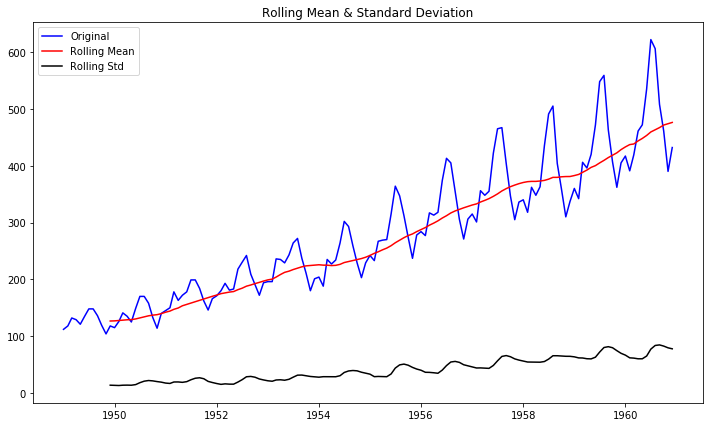

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
stationarity_check(d_series)

## Perform a log() and sqrt() transform

In [48]:
log_series = pd.Series(np.log(data.passengers.values),index=index)
log_series.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
dtype: float64

In [9]:
sqrt_series = pd.Series(np.sqrt(data.passengers.values),index=index)
sqrt_series.head()

Month
1949-01-01    10.583005
1949-02-01    10.862780
1949-03-01    11.489125
1949-04-01    11.357817
1949-05-01    11.000000
dtype: float64

moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

In [25]:
rolmean = log_series.rolling(window = 7).mean()
log_mean = log_series.values-rolmean.values
log_mean[:5]

array([nan, nan, nan, nan, nan])

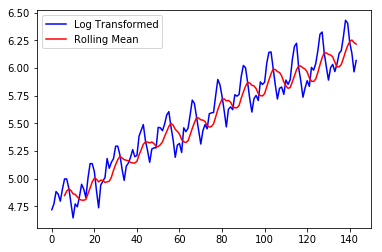

In [22]:
plt.plot(log_series.values, color='blue',label='Log Transformed')
plt.plot(rolmean.values, color='red', label='Rolling Mean')
plt.legend();    

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [6]:
# Subtract the moving average from the original data and check head for Nans

In [27]:
# Drop the NaN values from timeseries calculated above
log_mean=log_mean[~np.isnan(log_mean)]

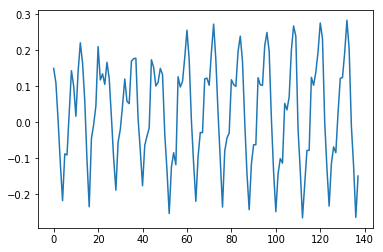

In [29]:
# Plot the result
plt.plot(log_mean);

Finally, use your function `check_stationarity` to see if this series is considered stationary!

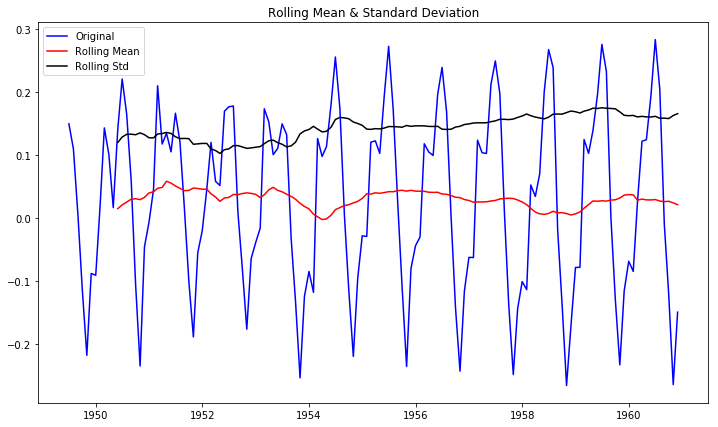

Test Statistic                  -2.348027
p-value                          0.156946
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [39]:
log_series = pd.Series(log,index=index[6:])
stationarity_check(log_series)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


By substracting the rolling mean we have transformed our time-series into one that is more stationary, but even still our confidence is low that we can reject the null hypothesis. 

## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

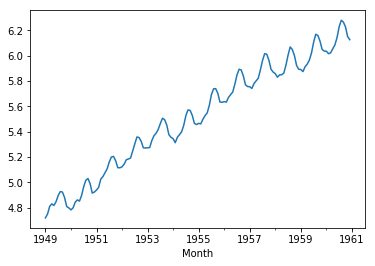

In [49]:
log_rolmean = log_series.ewm(halflife = 2).mean()
log_weighted = log_series-log_rolmean
# Plot the original data with exp weighted average
log_rolmean.plot();

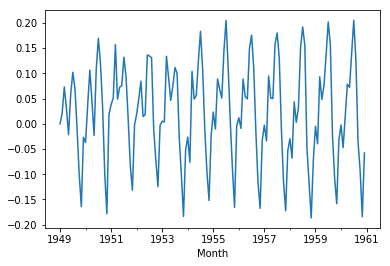

In [50]:
# Subtract the moving average from the original data and plot
log_weighted.plot();

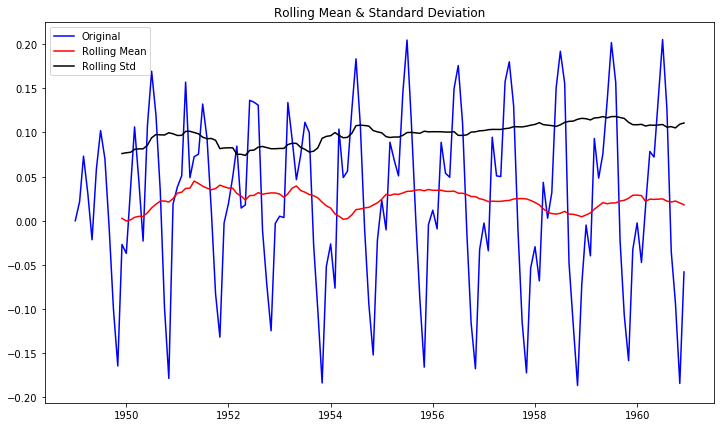

Test Statistic                  -3.087696
p-value                          0.027477
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [51]:
# do a stationarity check
stationarity_check(log_weighted)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


Subtracting the rolling mean from our log transformed series has led to a stationary series of which we have a high degree of confidence.

## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [52]:
# difference your data and look at the head
data_diff = log_weighted.diff(periods=1)
data_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.021616
1949-03-01    0.051525
1949-04-01   -0.042575
1949-05-01   -0.052119
dtype: float64

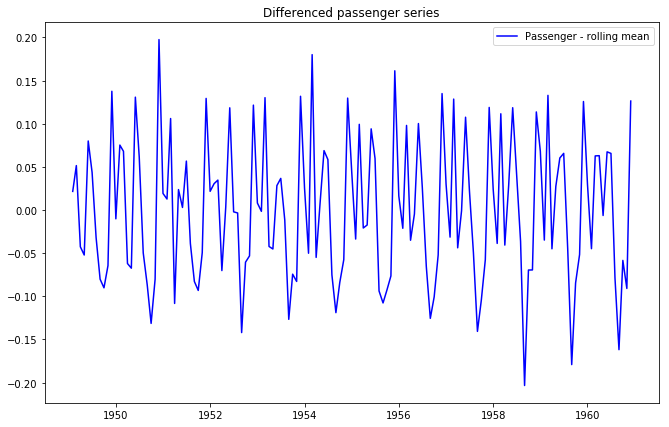

In [57]:
# plot your differenced time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Passenger - rolling mean')
plt.legend(loc='best')
plt.title('Differenced passenger series')
plt.show(block=False)

In [55]:
# drop nas
data_diff=data_diff[~data_diff.isnull()]

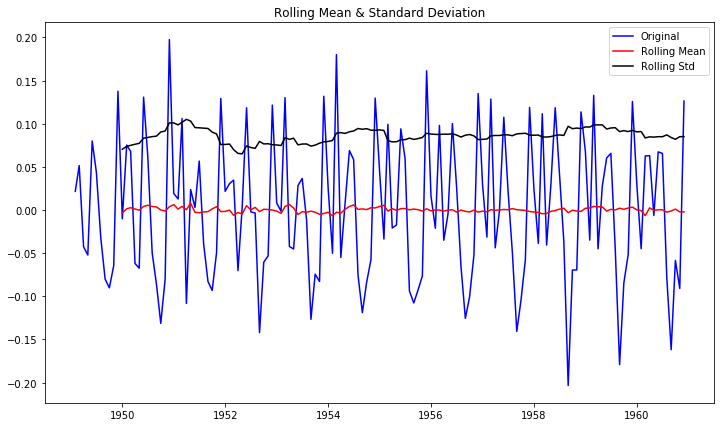

Test Statistic                  -4.042240
p-value                          0.001205
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [56]:
# perform the stationarity check
stationarity_check(data_diff)

### Your conclusion

We are now super confident that it is stationary.

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.